In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class Value:
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label

	def __repr__(self):
		return f"Value(data={self.data}, label={self.label})"

	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')

		def _backward():
			self.grad += out.grad
			other.grad += out.grad
		out._backward = _backward

		return out

	def __radd__(self, other):
		return self + other

	def __neg__(self):
		return self * -1

	def __sub__(self, other):
		return self + (-other)

	def __rsub__(self, other):
		return (-self) + other

	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')

		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward

		return out

	def __rmul__(self, other):
		return self * other

	def __truediv__(self, other):
		return self * (other**-1)

	def __rtruediv__(self, other):
		return other * (self**-1)

	def __pow__(self, other):
		assert isinstance(other, (int, float)), "only supporting int/float powers for now"
		out = Value(self.data**other, (self, ), f'**{other}')

		def _backward():
			self.grad += other * (self.data ** (other - 1)) * out.grad
		out._backward = _backward

		return out

	def tanh(self):
		x = self.data
		t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
		out = Value(t, (self, ), 'tanh')

		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward

		return out

	def relu(self):
		out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

		def _backward():
			self.grad += (out.data > 0) * out.grad
		out._backward = _backward

		return out

	def exp(self):
		x = self.data
		out = Value(math.exp(x), (self, ), 'exp')

		def _backward():
			self.grad += out.data * out.grad
		out._backward = _backward

		return out

	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)
		self.grad = 1.0
		for node in reversed(topo):
			node._backward()


In [3]:
from graphviz import Digraph

def trace(root):
	# builds a set of all nodes and edges in a graph
	nodes, edges = set(), set()
	def build(v):
		if v not in nodes:
			nodes.add(v)
		for child in v._prev:
			edges.add((child, v))
			build(child)
	build(root)
	return nodes, edges

def draw_dot(root):
	dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
	
	nodes, edges = trace(root)
	for n in nodes:
		uid = str(id(n))
		# for any value in the graph, create a rectangular ('record') node for it
		dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
		if n._op:
			# if this value is a result of some operation, create an op node for it
			dot.node(name = uid + n._op, label = n._op)
			# and connect this node to it
			dot.edge(uid + n._op, uid)

	for n1, n2 in edges:
		# connect n1 to the op node of n2
		dot.edge(str(id(n1)), str(id(n2)) + n2._op)

	return dot

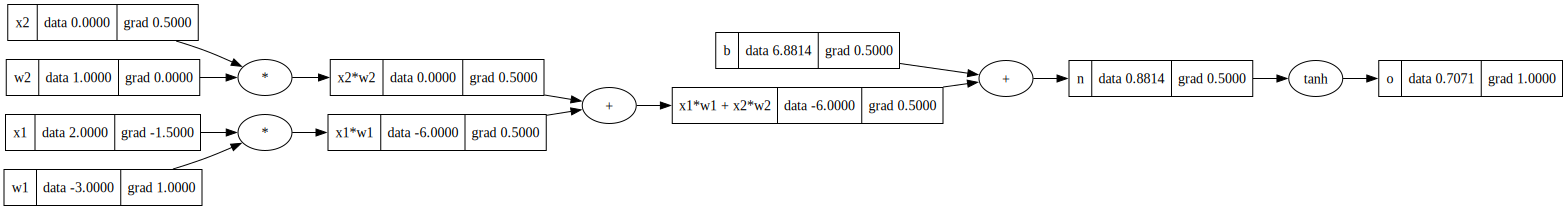

In [4]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

In [5]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
	def __init__(self, nin):
		self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
		self.b = Value(random.uniform(-1,1))

	def __call__(self, x):
		# x is a list of values, z = x1w1 + x2w2 + ... + xnwn + b
		act = sum((xi*wi for xi,wi in zip(x, self.w)), self.b)
		return act.tanh()

	def parameters(self): 
		return self.w + [self.b]

class Layer(Module):
	def __init__(self, nin: int, nout: int):
		self.neurons = [Neuron(nin) for _ in range(nout)]

	def __call__(self, x):
		out = [n(x) for n in self.neurons]
		return out[0] if len(out) == 1 else out

	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP(Module):
	def __init__(self, nin: int, nouts: list[int]):
		sizes = [nin] + nouts
		self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x

	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]


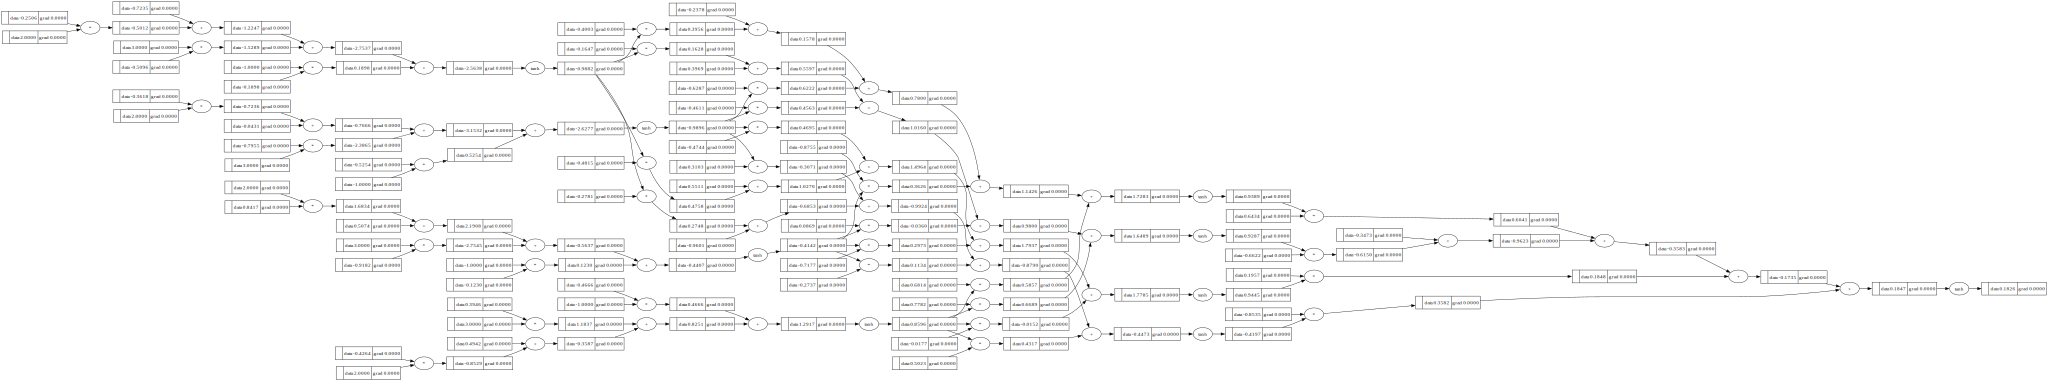

In [6]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))


In [7]:

xs = [
	[2.0, 3.0, -4],
	[1, -3, -2, 4],
	[3, -4, 5, -2],
	[2, 1, -4, 3],
	[3, 1, -3, 2],
]

ys = [1.0, -1, -1, 1, 1] # desired target outputs

for k in range(20):

	# forward pass
	ypreds = [n(x) for x in xs]
	loss = sum((yout - y)**2 for yout, y in zip(ypreds, ys))

	for p in n.parameters():
		p.grad = 0

	# backward pass
	loss.backward()

	# update weights
	for p in n.parameters():
		p.data -= 0.05 * p.grad

	print(k, loss.data)

print(['%.4f' % yout.data for yout in ypreds])

0 6.867171498988847
1 0.8815920469602943
2 0.34569757258307443
3 0.22890439996633322
4 0.17168831227459244
5 0.13735512837799965
6 0.1144092079776014
7 0.09798197115906075
8 0.08564090580464377
9 0.07603157740070925
10 0.06833896148571482
11 0.06204294008409744
12 0.05679589612103331
13 0.05235665373603024
14 0.04855263348867813
15 0.04525708792985883
16 0.042374839975412214
17 0.03983303475048313
18 0.03757496212185031
19 0.03555582267173174
['0.9492', '-0.9188', '-0.8833', '0.9220', '0.9183']


In [8]:
np.random.seed(1337)
random.seed(1337)

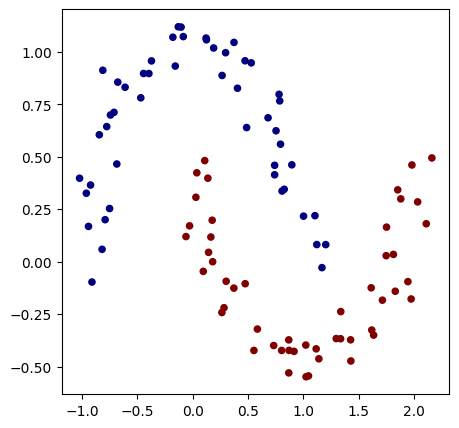

In [9]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [10]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [11]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.7840043023159259, label=) 0.68


In [12]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.7840043023159259, accuracy 68.0%
step 1 loss 0.5346887893624205, accuracy 73.0%
step 2 loss 0.4048611239882639, accuracy 83.0%
step 3 loss 0.3380828095624803, accuracy 86.0%
step 4 loss 0.29426189790330415, accuracy 88.0%
step 5 loss 0.2713707188453524, accuracy 90.0%
step 6 loss 0.2557758037037018, accuracy 90.0%
step 7 loss 0.24353269446140008, accuracy 91.0%
step 8 loss 0.23311666335881745, accuracy 91.0%
step 9 loss 0.22371429713875027, accuracy 91.0%
step 10 loss 0.21478840620418208, accuracy 91.0%
step 11 loss 0.2060314219010388, accuracy 91.0%
step 12 loss 0.19722264277587237, accuracy 92.0%
step 13 loss 0.18824544635214918, accuracy 93.0%
step 14 loss 0.17902966856680735, accuracy 94.0%
step 15 loss 0.1696750054539221, accuracy 94.0%
step 16 loss 0.1603343984865978, accuracy 94.0%
step 17 loss 0.15200986278726364, accuracy 96.0%
step 18 loss 0.14550876426551518, accuracy 96.0%
step 19 loss 0.15276142639895732, accuracy 95.0%
step 20 loss 0.14406510423987687, accur

(-1.548639298268643, 1.951360701731357)

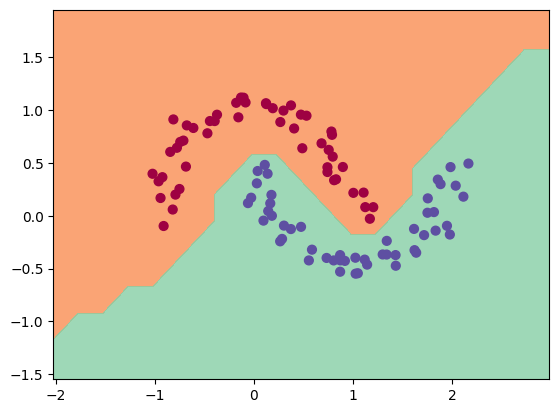

In [13]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
	np.arange(x_min, x_max, h),
	np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())